In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

#WordCloud
from wordcloud import WordCloud

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [97]:
# DATASET
dataset_Encoding = "ISO-8859-1"
train_size = 0.8

# TEXT CLENAING
text_cleaning = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
w2v_Size = 325
w2v_Window = 8
w2v_Epochs = 50
w2v_Min_Count = 10

# KERAS
sequence_Length = 300
epochs = 8
batch_Size = 1024

# SENTIMENT
positive = "POSITIVE"
negative = "NEGATIVE"
sentiment_Thresholds = (0.004)

# EXPORT
keras_Model = "model.h5"
word2vec_Model = "model.w2v"
tokenizer_Model = "tokenizer.pkl"
encoder_Model = "encoder.pkl"

In [3]:
#IMPORT
df = pd.read_csv('train.csv', encoding = dataset_Encoding )

In [4]:
print("Dataset size:", len(df))

Dataset size: 31962


In [5]:
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


### Mapping

positive -> 1

negative -> 0

In [6]:
df_copy = df.copy()

In [7]:
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_copy.label = df.label.apply(lambda x: decode_sentiment(x))

Wall time: 12 ms


In [9]:
df_copy

,id,label,tweet
0,1,NEGATIVE,@user when a father is dysfunctional and is s...
1,2,NEGATIVE,@user @user thanks for #lyft credit i can't us...
2,3,NEGATIVE,bihday your majesty
3,4,NEGATIVE,#model i love u take with u all the time in ...
4,5,NEGATIVE,factsguide: society now #motivation
...,...,...,...
31957,31958,NEGATIVE,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31958,31959,NEGATIVE,to see nina turner on the airwaves trying to...
31959,31960,NEGATIVE,listening to sad songs on a monday morning otw...
31960,31961,POSITIVE,"@user #sikh #temple vandalised in in #calgary,..."


In [10]:
#Negative and Positive count 
label_cnt = Counter(df_copy.label)
label_cnt

Counter({'NEGATIVE': 29720, 'POSITIVE': 2242})

Text(0.5, 1.0, 'Veri kümesi etiketleri dağıtımı')

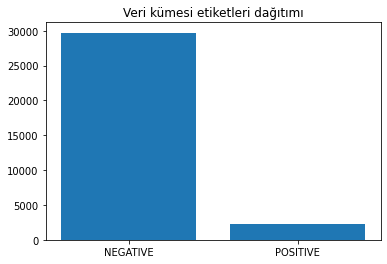

In [11]:
plt.figure()
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Label Distribution")

# Data Cleaning and Preprocessing

In [13]:
#remove sparse terms
terms = pd.Series(' '.join(df_copy['tweet']).split()).value_counts()[-1000:]
df_copy['tweet'] = df_copy['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in terms))
df_copy

,id,label,tweet
0,1,NEGATIVE,@user when a father is dysfunctional and is so...
1,2,NEGATIVE,@user @user thanks for #lyft credit i can't us...
2,3,NEGATIVE,bihday your majesty
3,4,NEGATIVE,#model i love u take with u all the time in ur...
4,5,NEGATIVE,factsguide: society now #motivation
...,...,...,...
31957,31958,NEGATIVE,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31958,31959,NEGATIVE,to see nina turner on the airwaves trying to w...
31959,31960,NEGATIVE,listening to sad songs on a monday morning otw...
31960,31961,POSITIVE,"@user #sikh #temple vandalised in in #calgary,..."


In [14]:
#stopwords
stop_words = stopwords.words("english")
#stemming
stemmer = SnowballStemmer("english")


def preprocess(text, stem = False):
    text = re.sub(text_cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
df_copy.tweet = df_copy.tweet.apply(lambda x: preprocess(x))
df_copy

,id,label,tweet
0,1,NEGATIVE,father dysfunctional selfish drags kids dysfun...
1,2,NEGATIVE,user thanks lyft credit use cause offer wheelc...
2,3,NEGATIVE,bihday majesty
3,4,NEGATIVE,model love u take u time ur
4,5,NEGATIVE,factsguide society motivation
...,...,...,...
31957,31958,NEGATIVE,ate user isz youuu
31958,31959,NEGATIVE,see nina turner airwaves trying wrap mantle ge...
31959,31960,NEGATIVE,listening sad songs monday morning otw work sad
31960,31961,POSITIVE,sikh temple vandalised calgary wso condemns act


# World Cloud

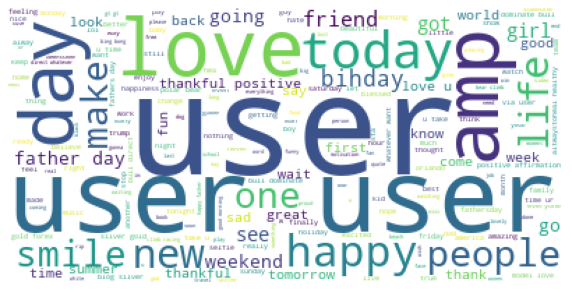

In [16]:
text = " ".join(i for i in df_copy.tweet)

wordcloud = WordCloud(max_font_size = 100,
                     background_color = "white").generate(text)
plt.figure(figsize = [10,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Split train and test

In [17]:
df_train, df_test = train_test_split(df_copy, test_size=1-train_size, random_state=42)
print("Train Size:", len(df_train))
print("Test Size:", len(df_test))

Train boyutu: 25569
Test boyutu: 6393


## Word2Vec

In [18]:
%%time
#create documents
documents = [word.split() for word in df_train.tweet] 

Wall time: 29.9 ms


In [19]:
documents

[['user', 'user', 'paying', 'attention', 'past', 'year', '8', 'years'],
 ['raft',
  'building',
  'salford',
  'quays',
  'pa',
  'gmw',
  'fun',
  'outdoors',
  'badge',
  'guides',
  'user'],
 ['friday',
  'gdegblog',
  'friday',
  'selfie',
  'beard',
  'gayguy',
  'gaymen',
  'gaystyle',
  'lifestyle',
  'fullness'],
 ['fashion', 'true', 'fact'],
 ['share',
  'simple',
  'elegant',
  'businesscards',
  'designed',
  'gracious',
  'muse',
  'jewelry'],
 ['big',
  'update',
  'user',
  'colne',
  'uk',
  'european',
  'blues',
  '35th',
  'anniversary',
  'event',
  'mondays',
  'blueshour',
  'bet'],
 ['five',
  'minutes',
  'google',
  'translate',
  'print',
  'sign',
  'would',
  'fix',
  'nonsense',
  'paxex'],
 ['lady',
  'graces',
  'berniesanders',
  'according',
  'guccifer2',
  'dnc',
  'never',
  'going',
  '2',
  'let',
  'u',
  'compete',
  'equally',
  'amp',
  'disappointed'],
 ['simple',
  'things',
  'life',
  'make',
  'one',
  'happy',
  'smile',
  'photography',
 

In [20]:
#create word2vec model 
w2v_model = gensim.models.word2vec.Word2Vec(size = w2v_Size, 
                                            window = w2v_Window, 
                                            min_count = w2v_Min_Count, 
                                            workers = 8)

In [21]:
#Build vocabulary from a sequence of sentences
w2v_model.build_vocab(documents)#

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab Size:", vocab_size)
#unique vocab size

Kelime Sayısı: 2858


In [23]:
len(documents) ## all words size

25569

In [24]:
%%time
#train model
w2v_model.train(documents, total_examples = len(documents), epochs = w2v_Epochs)

Wall time: 6.46 s


(6858634, 10443300)

### 10 most similar word

In [25]:
w2v_model.most_similar("father")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fathers', 0.6977015733718872),
 ('papa', 0.5939105749130249),
 ('dad', 0.572801411151886),
 ('daddy', 0.5412819385528564),
 ('fathersday', 0.5298136472702026),
 ('dads', 0.5186811089515686),
 ('son', 0.4729066491127014),
 ('daughter', 0.44744476675987244),
 ('hero', 0.4321988523006439),
 ('lord', 0.4099755585193634)]

In [26]:
w2v_model.most_similar("day")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('thing', 0.34365999698638916),
 ('fathersday', 0.339834064245224),
 ('latepost', 0.3266642689704895),
 ('morning', 0.31602585315704346),
 ('goodday', 0.2965899109840393),
 ('time', 0.2919224202632904),
 ('monday', 0.2872375249862671),
 ('cheers', 0.27485454082489014),
 ('hanging', 0.27424827218055725),
 ('trip', 0.2718236744403839)]

In [27]:
#bu şekilde bi kullanışıda var
w2v_model.most_similar(positive=['girl', 'father'], negative=['man'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('fathers', 0.39710643887519836),
 ('hump', 0.3635472059249878),
 ('dad', 0.3371683955192566),
 ('fathersday', 0.33600929379463196),
 ('broke', 0.3348022401332855),
 ('papa', 0.33438044786453247),
 ('daddy', 0.3320654332637787),
 ('daughter', 0.3268246054649353),
 ('toptags', 0.32631829380989075),
 ('goodmood', 0.3222943842411041)]

## Tokenization

In [28]:
%%time
tokenizer = Tokenizer()
# train verisine göre tokenizer sınıfının ayarlanması
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1


Toplam  33483  adet farklı kelime bulunmaktadır
Wall time: 397 ms


In [30]:
#father count in tokenizer
tokenizer.word_counts['father']

513

In [35]:
tokenizer.texts_to_sequences(df_train.tweet)

[[1, 1, 2119, 1232, 694, 90, 448, 177],
 [12920, 1419, 12921, 12922, 276, 12923, 26, 2639, 6430, 8443, 1],
 [35, 8444, 35, 96, 1700, 12924, 12925, 12926, 436, 12927],
 [220, 173, 393],
 [371, 743, 3889, 8445, 3890, 8446, 6431, 1701],
 [182, 602, 1, 12928, 445, 2449, 1988, 4479, 636, 603, 3891, 12929, 1155],
 [1887, 744, 1233, 8447, 2859, 916, 117, 2120, 6432, 12930],
 [938, 12931, 4480, 2640, 12932, 3892, 60, 43, 24, 107, 7, 6433, 5255, 4, 695],
 [743, 102, 6, 31, 18, 5, 20, 401, 2, 12933],
 [12934, 696, 59, 12935, 3137, 12936],
 [1, 1, 41, 252, 360, 5256, 785, 133],
 [135, 4, 75, 10, 895, 299, 347, 1188, 560],
 [11, 745, 1989, 12937, 1377, 1102, 12938, 12939, 1, 1, 11, 1989],
 [12940, 552, 253, 963, 455, 54, 622, 2641, 1, 1],
 [661, 8448, 283, 308, 833, 43, 14, 585, 418, 308, 45],
 [12941, 5257, 272, 10, 21, 6434],
 [1, 317, 697],
 [5, 17, 1103, 8449, 12942, 167, 1103, 8449],
 [22, 21, 12943, 98, 75, 1625],
 [34, 5258, 12944, 8450, 1990, 3893, 12945],
 [2259, 12946, 145, 4481, 2121, 2

In [36]:
#all data is 300 in length
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweet), maxlen = sequence_Length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen = sequence_Length)

In [37]:
labels = df_train.label.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [38]:
x_train

array([[    0,     0,     0, ...,    90,   448,   177],
       [    0,     0,     0, ...,  6430,  8443,     1],
       [    0,     0,     0, ..., 12926,   436, 12927],
       ...,
       [    0,     0,     0, ...,    78,    56,  1871],
       [    0,     0,     0, ..., 33481, 33482,   383],
       [    0,     0,     0, ...,  7237,    41,  1777]])

In [39]:
#label encoding
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

LabelEncoder()

In [40]:
y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())
print(y_train)
print(y_test)

[1 0 0 ... 1 0 0]
[0 0 0 ... 0 0 1]


In [41]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train)
print(y_test)

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [42]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (25569, 300)
y_train (25569, 1)


In [43]:
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_test (6393, 300)
y_test (6393, 1)


In [44]:
print(x_train) 

[[    0     0     0 ...    90   448   177]
 [    0     0     0 ...  6430  8443     1]
 [    0     0     0 ... 12926   436 12927]
 ...
 [    0     0     0 ...    78    56  1871]
 [    0     0     0 ... 33481 33482   383]
 [    0     0     0 ...  7237    41  1777]]


In [45]:
print(y_train) 

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


### Embedding Layer

In [47]:
tokenizer.word_index.items()

dict_items([('user', 1), ('love', 2), ('day', 3), ('amp', 4), ('happy', 5), ('life', 6), ('u', 7), ('time', 8), ('today', 9), ('like', 10), ('new', 11), ('positive', 12), ('thankful', 13), ('get', 14), ('people', 15), ('good', 16), ('bihday', 17), ('one', 18), ('see', 19), ('smile', 20), ('go', 21), ('want', 22), ('father', 23), ('2', 24), ('take', 25), ('fun', 26), ('work', 27), ('weekend', 28), ('healthy', 29), ('summer', 30), ('make', 31), ('family', 32), ('got', 33), ('us', 34), ('friday', 35), ('best', 36), ('great', 37), ('beautiful', 38), ('friends', 39), ('need', 40), ('way', 41), ('bull', 42), ('going', 43), ('days', 44), ('first', 45), ('wait', 46), ('world', 47), ('ur', 48), ('back', 49), ('really', 50), ('music', 51), ('morning', 52), ('cute', 53), ('tomorrow', 54), ('3', 55), ('week', 56), ('orlando', 57), ('know', 58), ('sad', 59), ('never', 60), ('fathersday', 61), ('think', 62), ('happiness', 63), ('trump', 64), ('right', 65), ('home', 66), ('sunday', 67), ('night', 68)

In [48]:
w2v_Size

325

In [49]:
vocab_size

33483

In [50]:
"""
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
"""

'\nwords = w2v_model.wv.vocab.keys()\nvocab_size = len(words)\nprint("Kelime Sayısı:", vocab_size)\n'

In [51]:
#filling embedding matrix
embedding_matrix = np.zeros((vocab_size, w2v_Size))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        
print(embedding_matrix.shape)

(33483, 325)


In [52]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24372515,  0.04818799,  0.59599137, ..., -0.24882698,
         0.52759033,  0.54437017],
       [ 1.15044832,  0.43096685, -0.01268175, ..., -0.53262478,
        -0.0451763 , -0.15461299],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
embedding_layer = Embedding(vocab_size, w2v_Size, weights=[embedding_matrix], input_length = sequence_Length, trainable = False)

## Build Model

In [54]:
model = Sequential()

In [55]:
model.add(embedding_layer)

In [56]:
model.add(Dropout(0.5))

In [57]:
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))


In [58]:
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 325)          10881975  
_________________________________________________________________
dropout (Dropout)            (None, 300, 325)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               170400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 11,052,476
Trainable params: 170,501
Non-trainable params: 10,881,975
_________________________________________________________________


## Compile model

In [60]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy']) #

## Callbacks

In [61]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Train

In [62]:
%%time
history = model.fit(x_train, y_train, batch_size = batch_Size, epochs = epochs, validation_split = 0.1, verbose = 1, callbacks = callbacks)

Epoch 1/8
23/23 [==============================] - 229s 9s/step - loss: 0.4735 - accuracy: 0.8132 - val_loss: 0.1727 - val_accuracy: 0.9390
Epoch 2/8
23/23 [==============================] - 232s 10s/step - loss: 0.1796 - accuracy: 0.9349 - val_loss: 0.1542 - val_accuracy: 0.9460
Epoch 3/8
23/23 [==============================] - 266s 12s/step - loss: 0.1632 - accuracy: 0.9390 - val_loss: 0.1476 - val_accuracy: 0.9480
Epoch 4/8
23/23 [==============================] - 265s 12s/step - loss: 0.1555 - accuracy: 0.9403 - val_loss: 0.1409 - val_accuracy: 0.9484
Epoch 5/8
23/23 [==============================] - 275s 12s/step - loss: 0.1477 - accuracy: 0.9460 - val_loss: 0.1402 - val_accuracy: 0.9488
Epoch 6/8
23/23 [==============================] - 292s 13s/step - loss: 0.1417 - accuracy: 0.9490 - val_loss: 0.1362 - val_accuracy: 0.9480
Epoch 7/8
23/23 [==============================] - 302s 13s/step - loss: 0.1394 - accuracy: 0.9486 - val_loss: 0.1311 - val_accuracy: 0.9503
Epoch 8/8
23/2

In [63]:
%%time
score = model.evaluate(x_test, y_test, batch_size=batch_Size)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

7/7 [==============================] - 11s 2s/step - loss: 0.1389 - accuracy: 0.9499

ACCURACY: 0.9499452710151672
LOSS: 0.13886795938014984
Wall time: 11.5 s


In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#best epoch value
epochs = range(len(acc))

In [65]:
epochs

range(0, 8)

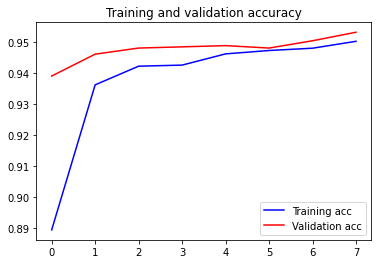

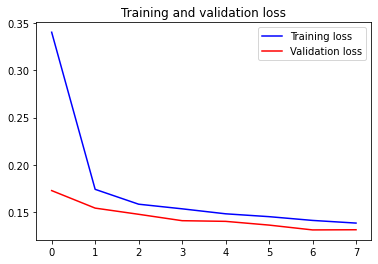

In [67]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [98]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        if score <= sentiment_Thresholds:
            label = positive
        elif score >= sentiment_Thresholds:
            label = negative

        return label
    else:
        return negative if score < 0.5 else positive

In [99]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # tokenizer test data
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=sequence_Length)
    # predict score
    score = model.predict([x_test])[0]
    # decode sentiment 
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [101]:
predict("i love you father")

{'label': 'POSITIVE',
 'score': 0.0020447373390197754,
 'elapsed_time': 0.06081795692443848}

In [102]:
predict("I hate the father")

{'label': 'NEGATIVE',
 'score': 0.10403826832771301,
 'elapsed_time': 0.06183624267578125}

In [106]:
y_pred_1d = []
y_test_1d = list(df_test.label)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 7s 7s/step


In [107]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

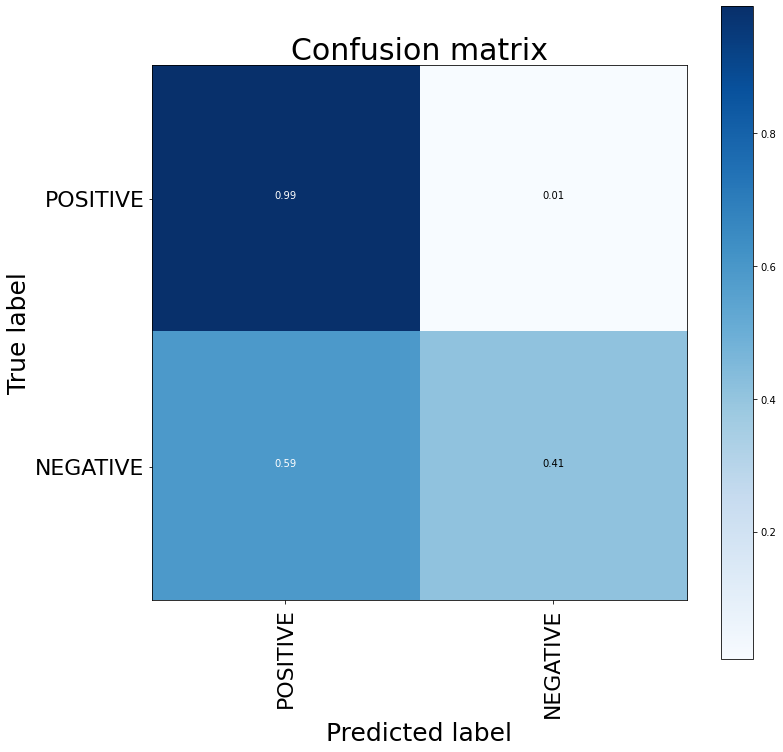

In [109]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.label.unique(), title="Confusion matrix")
plt.show()

In [111]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.97      5937
    POSITIVE       0.79      0.41      0.54       456

    accuracy                           0.95      6393
   macro avg       0.87      0.70      0.76      6393
weighted avg       0.94      0.95      0.94      6393

